## Section 1: Testing 4 models

### First model: Facebook Prophet

In [1]:
#installing facebook prophet on anaconda which I use
#conda install -c conda-forge fbprophet

In [2]:
#change the working directory to the relevant path on your computer if necessary (where you store the data!) 
#import os
#os.chdir('D:\/Downloads-D')
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error #to calculate metrics for the model later
#!pip install fbprophet
#!pip install statsmodels
#!pip install pmdarima
#un-comment the lines above if necessary
from fbprophet import Prophet #facebook prophet model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import math
from time import time
import datetime
%matplotlib inline
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
np.random.seed(2021)
%config InlineBackend.figure_format = 'retina'

Importing plotly failed. Interactive plots will not work.


Note: This notebook is created in an anaconda environment, with pandas version 1.0.5. If this notebook does not fully run for you, consider installing these components.

The implementation of the following Facebook Prophet model is based on the tutorial from Loukas (2020).

Loukas, S. (2020, July 31). Time-series forecasting: Predicting stock prices using facebook's prophet model. Retrieved March 20, 2021, from https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-facebooks-prophet-model-9ee1657132b5

In [3]:
# Load the dataset using pandas
#data from Yahoo Finance
parse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y') #set the format of the dates
dta = pd.read_csv('GOOG (2).csv',sep=',', parse_dates=['Date'], 
                  date_parser=parse).fillna(0) #fill in any NA values with 0
dta.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,EPS,Revenue,Gross profit,Operating Income,EBITDA,Net income,PE Ratio,ROE
0,2015-01-02,527.561584,529.815369,522.665039,523.373108,523.373108,1447500,6.67,18103,11182,4399,5666,4594,25.1,0.1449
1,2015-01-05,521.827332,522.894409,511.655243,512.463013,512.463013,2059800,6.67,18103,11182,4399,5666,4594,25.1,0.1449
2,2015-01-06,513.589966,514.761719,499.678131,500.585632,500.585632,2899900,6.67,18103,11182,4399,5666,4594,25.1,0.1449
3,2015-01-07,505.611847,505.855164,498.281952,499.727997,499.727997,2065000,6.67,18103,11182,4399,5666,4594,25.1,0.1449
4,2015-01-08,496.626526,502.101471,489.655640,501.303680,501.303680,3353500,6.67,18103,11182,4399,5666,4594,25.1,0.1449


In [4]:
#Facebook Prophet only takes date and closing price as inputs, so we only need these two columns
dta = dta[["Date","Close"]] 
# The two columns must also be named "ds" and "y" exactly for the model to run
dta = dta.rename(columns = {"Date":"ds","Close":"y"})

In [5]:
dta

,ds,y
0,2015-01-02,523.373108
1,2015-01-05,512.463013
2,2015-01-06,500.585632
3,2015-01-07,499.727997
4,2015-01-08,501.303680
...,...,...
1469,2020-11-02,1626.030029
1470,2020-11-03,1650.209961
1471,2020-11-04,1749.130005
1472,2020-11-05,1763.369995


In [6]:
#Fitting the prophet model to the data
model = Prophet() 
model.add_country_holidays(country_name='US') #including holidays in the model
model.fit(dta) 

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Note that I have not included daily seasonality as we do not have data on this. Weekly & yearly seasonality is included by default. It is because we have daily data, and therefore weekly and yearly seasonality can be identified.

Furthermore, after testing, I use additive seasonality (Default) rather than multiplicative, which yielded much worse results (MAPE of 0.1 for additive, versus MAPE of 0.97 for multiplicative). On a basic level, additive seasonality assumes a constant additive factor of seasonality, while multiplicative allows the seasonality effect to grow with the trend in the data. Intuitively, multiplicative is a better choice since we might expect that the higher the stock price, the larger the fluctuations. However, testing it on real data reveals that using multiplicative seasonality yielded much worse results, so I used additive. One possible explanation is that as the stock price gets higher, the seasonality effect does not increase that much (multiplicatively).

In [7]:
model.train_holiday_names #holidays included

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11      New Year's Day (Observed)
12        Veterans Day (Observed)
13    Independence Day (Observed)
dtype: object

In [8]:
#Predicting 180 days into the future
pred = model.make_future_dataframe(periods=180) 
pred_results = model.predict(pred)

The above prediction results show yhat_lower and yhat_upper as the lower and upper ranges of the price prediction.
yhat at the end is the true prediction of the stock price. These are the 3 variables we are interested in.

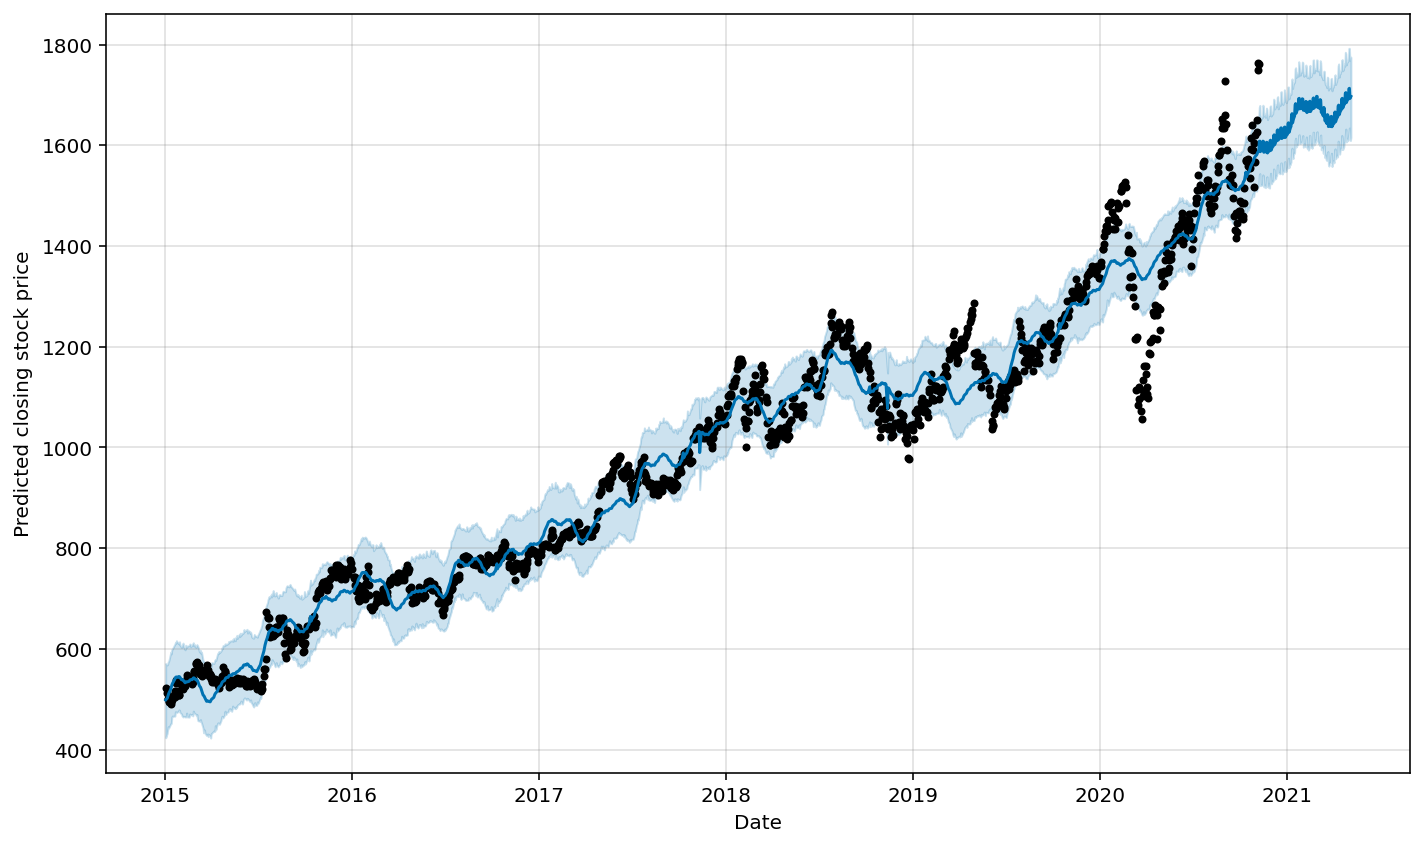

In [9]:
#Using the built in method for plotting the results in Facebook Prophet
model.plot(pred_results)
plt.xlabel("Date")
plt.ylabel("Predicted closing stock price")
plt.show()

The black dots are the actual data. The blue line is the stock price trend, and after the black dots is the prediction.
The lighter-shaded areas around the trend line are the yhat_lower and yhat_upper (95% confidence interval)

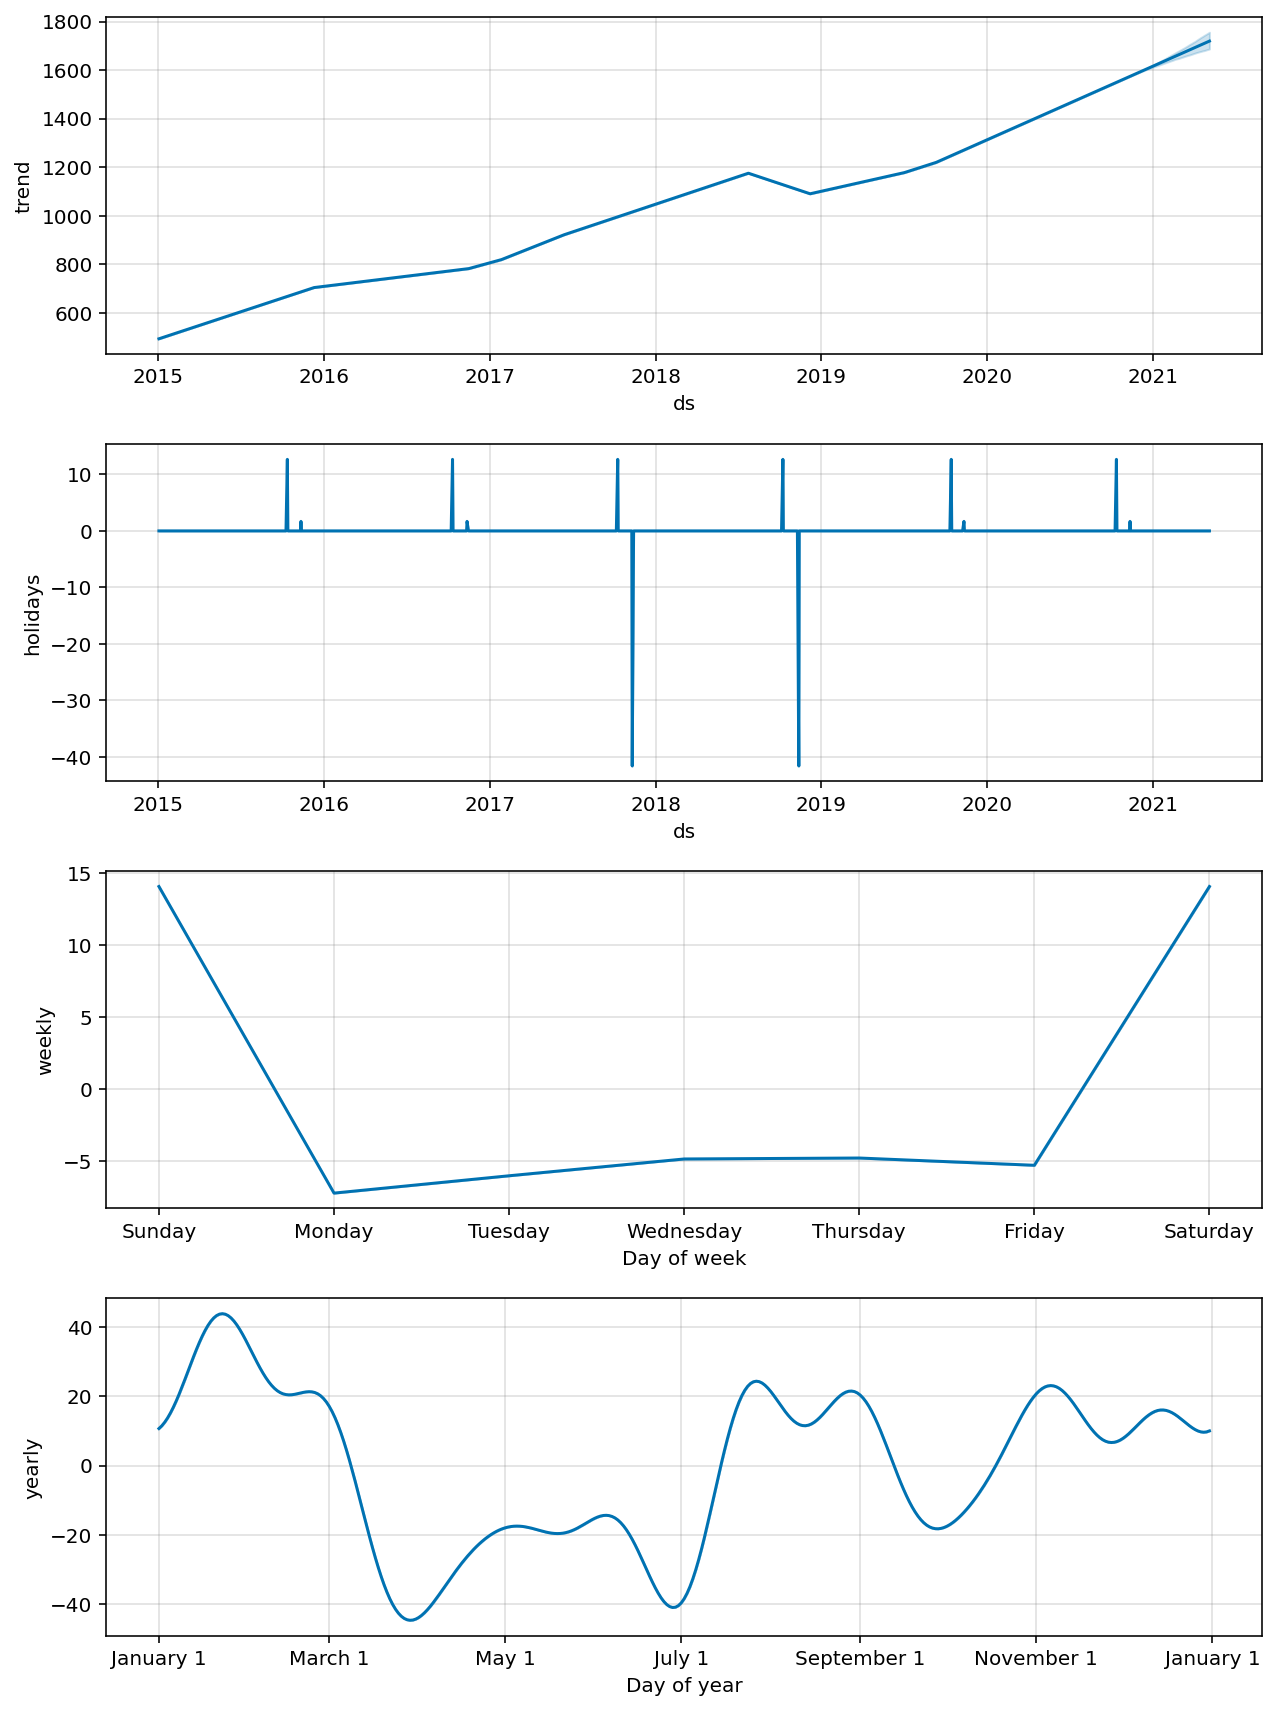

In [10]:
#breaking down the prediction of Facebook Prophet into its components: overall trend, daily, weekly and yearly trend
model.plot_components(pred_results)
plt.show()

Based on the results above we see that:

Overall trend for GOOG: overall upward trend (first graph)
. 
Weekly trend for GOOG: Up towards the middle of the week, then down towards the end. Weekends do not count since the 
market do not trade on weekends (third graph)

Yearly trend: Higher at the beginning of the two halves of the year (fourth graph)

### Testing Facebook Prophet###

Now, we split the data set and test the accuracy of the model

In [11]:
train_dta = dta[0:int(len(dta)*0.6)] #Training data: 60%
test_dta = dta[int(len(dta)*0.6):] #Test data: the remaining 40%
train_dta = train_dta.rename(columns = {"Date":"ds","Close":"y"}) #renaming as required by the model
model2 = Prophet() 
model2.add_country_holidays(country_name='US')

In [12]:
model2.fit(train_dta) # fit the model using the training data
pred2 = model2.make_future_dataframe(periods=590) #predict 578 days in the future (40% of the data)
pred_results2 = model2.predict(pred2)
prices = list(pred_results2['yhat'])
predicted_prices = prices[884:] #make the list of predicted prices to evaluate the model later

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
actual_prices = test_dta["y"].tolist()

In [14]:
# reporting model performance
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = math.sqrt(mean_squared_error(actual_prices, predicted_prices))
mape = np.mean(np.abs(np.array(predicted_prices) - actual_prices)/np.abs(actual_prices))
print('MSE: ', round(mse,2))
print('RMSE:', round(rmse,2))
print('MAPE: ', round(mape,2))

MSE:  19704.06
RMSE: 140.37
MAPE:  0.1


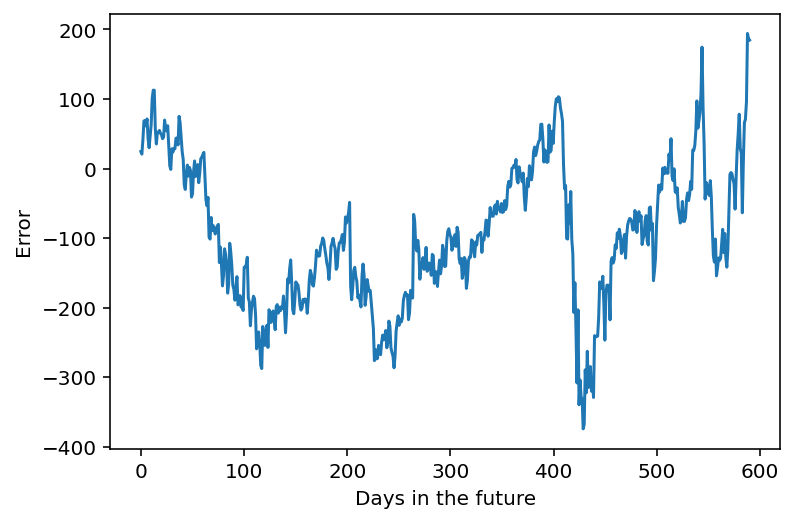

In [15]:
residuals = np.array(actual_prices) - np.array(predicted_prices)
x_axis = np.linspace(0, len(residuals),len(residuals))
plt.plot(x_axis,residuals)
plt.xlabel("Days in the future")
plt.ylabel("Error")
plt.show()

The interpretation of the metrics will be included in the write-up.

## Second model: ARIMA##

The implementation of the following ARIMA model is based on the tutorial from Chauhan (2020).

Chauhan, N. (2020). Stock market forecasting using time series analysis. Retrieved March 20, 2021, from https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html

In [16]:
parse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y') #set the format of the dates
dta2 = pd.read_csv('GOOG (2).csv',sep=',',index_col='Date', parse_dates=['Date'], date_parser=parse).fillna(0)
#Without the built-in functions in Facebook prophet, we want to make the index to be the date so it's intuitive
#and easy to graph later
dta2['Close']

Date
2015-01-02     523.373108
2015-01-05     512.463013
2015-01-06     500.585632
2015-01-07     499.727997
2015-01-08     501.303680
                 ...     
2020-11-02    1626.030029
2020-11-03    1650.209961
2020-11-04    1749.130005
2020-11-05    1763.369995
2020-11-06    1761.750000
Name: Close, Length: 1474, dtype: float64

In [17]:
dta2_close = dta2['Close']

In [18]:
#Test for stationarity - if the data is stationary, we have to "de-trend" it to use ARIMA
#Take rolling statistics to smoothen the data
rolling_average = dta2_close.rolling(12).mean()
rolling_std = dta2_close.rolling(12).std()


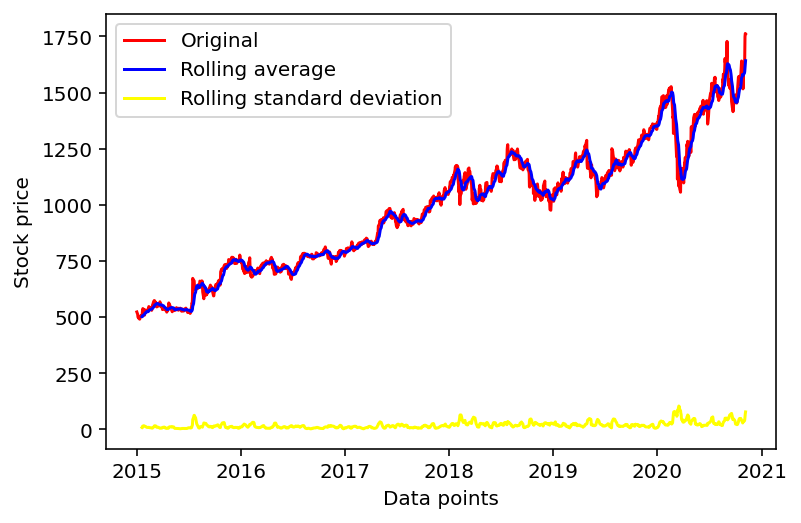

In [19]:
plt.figure()
plt.plot(dta2_close, label='Original', color='red')
plt.plot(rolling_average, label='Rolling average', color = 'blue')
plt.plot(rolling_std, label = 'Rolling standard deviation', color='yellow')
plt.legend()
plt.xlabel("Data points")
plt.ylabel("Stock price")
plt.show()

We see above that the data is NOT stationary. We will therefore take the log of the data for stationarity below

In [20]:
#Taking the log of the data for stationarity to apply the ARIMA model
dta2_log = np.log(dta2_close)
rolling_average_log = dta2_log.rolling(12).mean()
rolling_std_log = dta2_log.rolling(12).std()

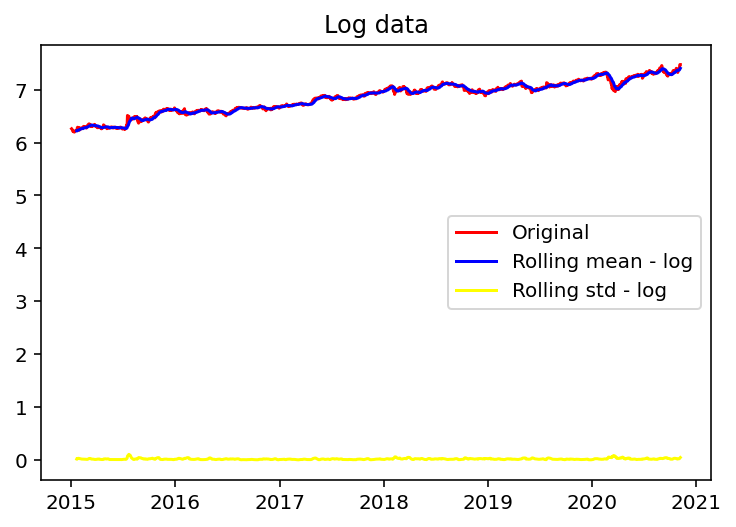

In [21]:
plt.plot(dta2_log, color='red', label='Original')
plt.plot(rolling_average_log, color ="blue", label = "Rolling mean - log")
plt.plot(rolling_std_log, color="yellow", label = "Rolling std - log")
plt.title('Log data')
plt.legend()
plt.show()


We see above that the data is now more stationary

In [22]:
train_data2 = dta2_log[:int(len(dta2_log)*0.6)] #train data: 60% of data like with Facebook Prophet
test_data2 = dta2_log[int(len(dta2_log)*0.6):] #test data: 40% of data remaining

In [23]:
#Implementing the model
#running auto_arima to figure out the optimal parameters for the model
model_autoARIMA = auto_arima(train_data2, start_p=0, start_q=0, test='adf', max_p=3, max_q=3, m=1, d=None, seasonal=True,
                             start_P=0, D=0,trace=True, error_action='ignore', suppress_warnings=True,stepwise=True)
#In the function above, start_p and start_q are simply starting points for the autoARIMA to tune the parameters.
#we also use the adf test to find the optimal parameter d
model_autoARIMA.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4972.046, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4973.972, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4974.097, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4970.766, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4972.339, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4972.324, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4970.320, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4973.230, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.656 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  884
Model:               SARIMAX(0, 1, 1)   Log Likelihood                2490.049
Date:                Sat, 20 Mar 2021   AIC                          -4974.097
Time:                        21:14:56   BIC                          -4959.747
Sample:                             0   HQIC                         -4968.610
                                - 884                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      1.632      0.103      -0.000       0.002
ma.L1          0.0651      0.026      2.531      0.011       0.015       0.115
sigma2         0.0002   4.13e-06     50.290      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       50.56   Jarque-Bera (JB):              7326.47
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Note: if you have a warning saying "Covariance matrix calculated using the outer product of gradients (complex-step)", it's safe to ignore it. It normally happens, and it only informs us how the covariance matrix is calculated.

In [24]:
model_arima = ARIMA(train_data2, order=(0, 1, 1))  #parameters found above
model_fit = model_arima.fit(disp=-1)  
model_fit.summary()

D:\Downloads-D\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Downloads-D\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  883
Model:                 ARIMA(0, 1, 1)   Log Likelihood                2490.055
Method:                       css-mle   S.D. of innovations              0.014
Date:                Sat, 20 Mar 2021   AIC                          -4974.111
Time:                        21:14:56   BIC                          -4959.761
Sample:                             1   HQIC                         -4968.624
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.001      1.698      0.089      -0.000       0.002
ma.L1.D.Close     0.0691      0.034      2.023      0.043       0.002       0.136
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1          -14.4810           +0.0000j           14.4810            0.5000
-----------------------------------------------------------------------------
"""

Note: you might get a warning saying that we have no associated frequency information regarding the date index. This just means that the forecast output will not have associated dates, which is fine.

In [25]:
# Deriving predictions
pred2, std_error, confint = model_fit.forecast(590, alpha=0.05)  #forecast 578 days - 40% of the data. Confint 95%

pred2_y = pd.Series(pred2, index=test_data2.index)

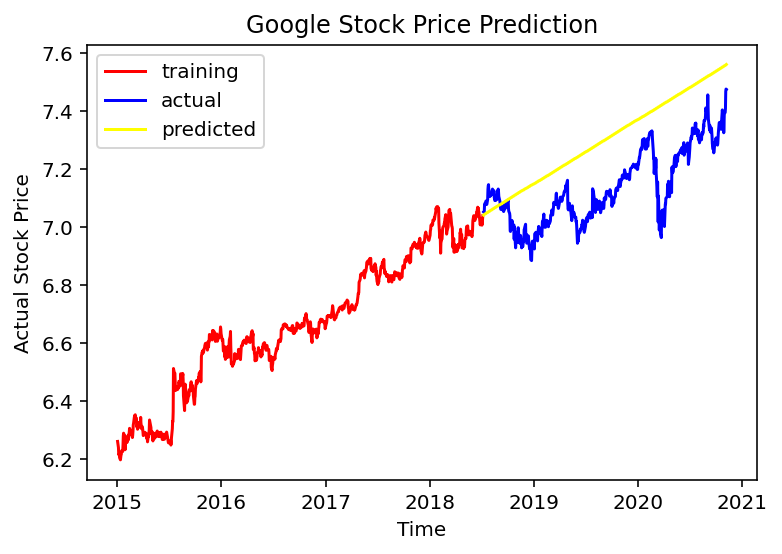

In [26]:
lower_pred_y = pd.Series(confint[:, 0], index=test_data2.index)
upper_pred_y = pd.Series(confint[:, 1], index=test_data2.index)
plt.figure()
plt.plot(train_data2, color='red', label='training')
plt.plot(test_data2, color = 'blue', label='actual')
plt.plot(pred2_y, color = 'yellow',label='predicted')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend()
plt.show()

The ARIMA model predicts a straight line, with the shaded area being the confidence interval of the predictions.
At a glance, we see that this is not too accurate

In [27]:
# report performance (un-logging the data first)
mse = mean_squared_error(np.exp(test_data2), np.exp(pred2))
rmse = math.sqrt(mean_squared_error(np.exp(test_data2), np.exp(pred2)))
mape = np.mean(np.abs(np.exp(pred2) - np.exp(test_data2))/np.abs(np.exp(test_data2)))
print('MSE: ', round(mse,2))
print('RMSE: ', round(rmse,2))
print('MAPE: ', round(mape,2))

MSE:  69992.65
RMSE:  264.56
MAPE:  0.19


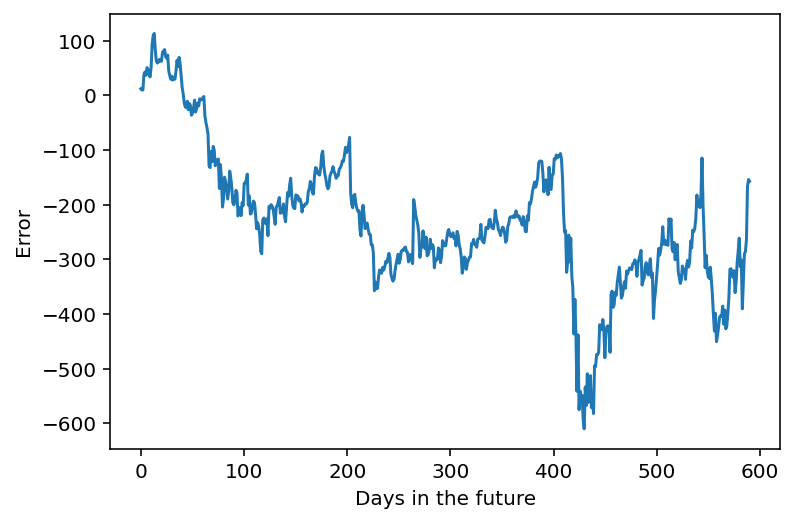

In [28]:
residuals = np.exp(test_data2) - np.exp(pred2)
x_axis = np.linspace(0, len(residuals),len(residuals))
plt.plot(x_axis,residuals)
plt.xlabel("Days in the future")
plt.ylabel("Error")
plt.show()

Interpretations of these metrics will be in the write-up.

## Third model: Random Forest 

The implementation of the following random forest model is based on the tutorial from Sigma Coding (2019).

Sigma Coding. (2019, December 19). Predicting stock price movement with random forests | introduction. Retrieved March 20, 2021, from https://www.youtube.com/watch?v=V8jZuOtckn8

In [29]:
#We can reuse the data from Facebook Prophet - no changes are needed
dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y') #set the format of the dates
dta3 = pd.read_csv('GOOG (2).csv',sep=',', parse_dates=['Date'], 
                  date_parser=dateparse).fillna(0)
dta3.head()

,Date,Open,High,Low,Close,Adj Close,Volume,EPS,Revenue,Gross profit,Operating Income,EBITDA,Net income,PE Ratio,ROE
0,2015-01-02,527.561584,529.815369,522.665039,523.373108,523.373108,1447500,6.67,18103,11182,4399,5666,4594,25.1,0.1449
1,2015-01-05,521.827332,522.894409,511.655243,512.463013,512.463013,2059800,6.67,18103,11182,4399,5666,4594,25.1,0.1449
2,2015-01-06,513.589966,514.761719,499.678131,500.585632,500.585632,2899900,6.67,18103,11182,4399,5666,4594,25.1,0.1449
3,2015-01-07,505.611847,505.855164,498.281952,499.727997,499.727997,2065000,6.67,18103,11182,4399,5666,4594,25.1,0.1449
4,2015-01-08,496.626526,502.101471,489.655640,501.303680,501.303680,3353500,6.67,18103,11182,4399,5666,4594,25.1,0.1449


#### We will include a number of technical indicators as features for the random forest model below. These features include RSI, Stochastic Oscillator, Price Rate of Change, Moving Average Convergence Divergence, Williams % R

#### Calculating RSI ####

This stands for Relative Strength Index. This indicator indicates when whether a stock is being overbought or oversold - when RSI is above 70, the stock is overbought, which means it is priced more highly than it deserves. This would likely lead to a subsequent fall in price. If RSI is below 70, the stock might be oversold, and will likely enjoy a price increase.

The formula for RSI is: 

$RSI = 100 - 100/(1+RS)$

RS - Relative Strength - is the exponential moving average (EWMA) of the average gain, divided by the EWMA of average loss of the past 14 days (conventionally). The EWMA makes it so that we give less weight to older days and more weight to more recent days.

Note: To avoid data leakage, we make it so that the RSI of each day is calculated only based on data of the last 14 days
excluding that day itself. We do this by pushing the up and down columns (representing price changes) backwards one day, then calculate EWMA.

In [30]:
def rsi_cal(dta3):
    '''
    Function to calculate the Relative Strength Index for each datapoint.
    Input: a pandas dataframe
    Output: the same dataframe with an extra column with RSI values
    '''
    
    dta3['change_in_price'] = dta3['Close'].diff() #create the change in price column which calculates gains/losses

    #now we need to create an "up" and a "down" column, containing gains/losses, to calculate the Relative Strength
    up = dta3[['change_in_price']].copy()
    down = dta3[['change_in_price']].copy()

    #up only contains gains, losses are marked as 0. down only contains losses, gains are marked as 0
    for i in range(len(up['change_in_price'])):
        if up['change_in_price'][i] < 0: 
            up['change_in_price'][i] = 0
        else:
            pass

    for i in range(len(down['change_in_price'])):
        if down['change_in_price'][i] >0: 
            down['change_in_price'][i] = 0
        else:
            down['change_in_price'][i] = abs(down['change_in_price'][i]) #we want all changes to be in absolute value


    #Avoid data leakage
    df_up = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_up = df_up.append(up['change_in_price'], ignore_index=True)
    df_up.drop(df_up.tail(1).index,inplace=True)
    up['change_in_price'] = df_up
    df_down = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_down = df_down.append(down['change_in_price'], ignore_index=True)
    df_down.drop(df_down.tail(1).index,inplace=True)
    down['change_in_price'] = df_down


    # Calculate the EWMA (Exponential Weighted Moving Average)
    ewma_up = up['change_in_price'].transform(lambda x: x.ewm(span = 14).mean())
    ewma_down = down['change_in_price'].transform(lambda x: x.ewm(span = 14).mean())

    # Calculate the RS
    RS = ewma_up/ewma_down

    # Calculate the RSI
    RSI = 100.0 - (100.0 / (1.0 + RS))

    dta3['down_days'] = down['change_in_price']
    dta3['up_days'] = up['change_in_price']
    dta3['RSI'] = RSI
    #We will drop the Nas latter
    return dta3

In the following subsection, I will provide a small dummy dataset to act as a test for my functions to calculate the indicators. Note that in the dummy dataset below, the "up" and "down" columns have been pushed backwards one day so that they are aligned with the above function calculations.

In [31]:
dummy = {'Close': [100,101,102,103,102,105,100,98,107,104,98,96,94,97,100,104,105,106,103,104,100,92,94,96,97,95,98,101],
         'up': [np.nan,np.nan, 1,1,1,0,3,0,0,9,0,0,0,0,3,3,4,1,1,0,1,0,0,2,2,1,0,3],
        'down': [np.nan,np.nan, 0,0,0,1,0,5,2,0,3,6,2,2,0,0,0,0,0,3,0,4,8,0,0,0,2,0]}
dummy_data = pd.DataFrame(data=dummy)
dummy_data

,Close,up,down
0,100,NaN,NaN
1,101,NaN,NaN
2,102,1.0,0.0
3,103,1.0,0.0
4,102,1.0,0.0
5,105,0.0,1.0
6,100,3.0,0.0
7,98,0.0,5.0
8,107,0.0,2.0
9,104,9.0,0.0


In [32]:
#Now, we manually calculate the RSI for this dataset, then we compare it with the result from the function
ewma_up = dummy_data['up'].transform(lambda x: x.ewm(span = 14).mean())
ewma_down = dummy_data['down'].transform(lambda x: x.ewm(span = 14).mean())
dummy_data['RSI']=100 - (100/(1+ewma_up/ewma_down))

In [33]:
dummy_data['RSI']

0            NaN
1            NaN
2     100.000000
3     100.000000
4     100.000000
5      69.407179
6      85.141775
7      42.804536
8      34.814513
9      66.897675
10     56.249575
11     41.138700
12     37.286180
13     33.650137
14     43.231509
15     51.339482
16     60.105537
17     62.076264
18     64.121289
19     54.034992
20     56.657234
21     44.848545
22     30.283081
23     36.254951
24     41.988628
25     44.850475
26     40.266378
27     49.244913
Name: RSI, dtype: float64

In [34]:
rsi_cal(dummy_data)['RSI']

0            NaN
1            NaN
2     100.000000
3     100.000000
4     100.000000
5      69.407179
6      85.141775
7      42.804536
8      34.814513
9      66.897675
10     56.249575
11     41.138700
12     37.286180
13     33.650137
14     43.231509
15     51.339482
16     60.105537
17     62.076264
18     64.121289
19     54.034992
20     56.657234
21     44.848545
22     30.283081
23     36.254951
24     41.988628
25     44.850475
26     40.266378
27     49.244913
Name: RSI, dtype: float64

We see above that the manually calculated RSI and the RSI from the function is the same. This means that we can be more confident in our function.

#### Calculating Stochastic Oscillator ####

The Stochastic Oscillator follows the momentum of the price, which usually changes before the price actually changes. In other words, it helps to indicate the very near term movement of the price.

Formula:

$K = 100*(Current closing price - L14)/(H14-L14)$

With H14 being the highest high in the last 14 days, and L14 being the lowest low in the last 14 days (exclusive of today).  To avoid data leakage, we calculate the oscillator using not that day's closing price, but the day before that.

In [35]:
def stoc_oscillator_cal(dta3):
    '''
    Function to calculate the Stochastic Oscillator for each datapoint.
    Input: a pandas dataframe
    Output: the same dataframe with an extra column with Stochastic Oscillator values
    '''
    #Creating the high and low columns
    high14 = dta3['Close'].copy()
    low14 = dta3['Close'].copy()
    close_pushed = dta3['Close'].copy()
    df_high = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_high = df_high.append(high14, ignore_index=True)
    df_high.drop(df_high.tail(1).index,inplace=True)
    high14 = df_high
    df_low = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_low = df_low.append(low14, ignore_index=True)
    df_low.drop(df_low.tail(1).index,inplace=True)
    low14 = df_low
    df_close = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_close = df_close.append(close_pushed, ignore_index=True)
    df_close.drop(df_close.tail(1).index,inplace=True)
    close_pushed = df_close


    # We use the roll function to calculate the H14 and L14
    high14 = high14.transform(lambda x: x.rolling(window = 14).max())
    low14 = low14.transform(lambda x: x.rolling(window = 14).min())

    # Calculation of Stochastic Oscillator.
    stoc_oscillator = 100 * ((close_pushed - low14) / (high14 - low14))
    dta3['low14'] = low14
    dta3['high14'] = high14
    dta3['k_percent'] = stoc_oscillator
    return dta3

Testing:

In [36]:
dummy_data[:15]

,Close,up,down,RSI,change_in_price,down_days,up_days
0,100,NaN,NaN,NaN,NaN,NaN,NaN
1,101,NaN,NaN,NaN,1.0,NaN,NaN
2,102,1.0,0.0,100.000000,1.0,0.0,1.0
3,103,1.0,0.0,100.000000,1.0,0.0,1.0
4,102,1.0,0.0,100.000000,-1.0,0.0,1.0
5,105,0.0,1.0,69.407179,3.0,1.0,0.0
6,100,3.0,0.0,85.141775,-5.0,0.0,3.0
7,98,0.0,5.0,42.804536,-2.0,5.0,0.0
8,107,0.0,2.0,34.814513,9.0,2.0,0.0
9,104,9.0,0.0,66.897675,-3.0,0.0,9.0


We use the dummy data above to manually calculate k-percent. Take the example of the fifteenth day (fourteenth line). The 14 days prior will be datapoints 0 to 13. The highest price is 107, and the lowest is 94. The current price is 97 (since we calculate based on past prices). Therefore, the k-percent is:

$100*(97-94)/(107-94) = 23.07$

In [37]:
stoc_oscillator_cal(dummy_data)['k_percent'][14]

23.076923076923077

We see above that the function result matches the manually calculated result.

#### Calculating Price Rate of Change ####

The price rate of change is intuitive: it is the rate of change between the most current closing price and the closing price of n days ago. Choosing n depends on the horizon of the investors: short-term traders typically choose a n=9, while longer term investors often use larger n values, up to 200. Since our intended audience is longer-term investors, we take n=50 - we can afford to throw away 49 data points (The first 49 data points will have NaN values). Throwing away 200 data points is too much for our dataset.

Again, to avoid data leakage, the "current closing price" is interpreted to be the closest known closing price on a given day, which is that of one day earlier.

The indicator measures the momentum of the stock - a rising PRC above zero typically signals upward movement. A PRC that hovers near zero often indicate a consolidating price.

In [38]:
def prc_cal(dta3):
    '''
    Function to calculate the Price Rate of Change for each datapoint.
    Input: a pandas dataframe
    Output: the same dataframe with an extra column with PRC values
    '''
    #the pct_change function helps us calculate the percentage change compared to n periods before
    close_pushed = dta3['Close'].copy()
    df_close = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_close = df_close.append(close_pushed, ignore_index=True)
    df_close.drop(df_close.tail(1).index,inplace=True)
    close_pushed = df_close
    dta3['PRC'] = close_pushed.transform(lambda x: x.pct_change(periods = 50))
    return dta3

Testing:

Since we have n=50, the above dummy dataset no longer applies (it has less than 50 datapoints). We will instead take the original data then perform manual calculations instead:

In [39]:
dta3[0:52]['Close']

0     523.373108
1     512.463013
2     500.585632
3     499.727997
4     501.303680
5     494.811493
6     491.201416
7     494.821472
8     499.498627
9     500.416107
10    506.688873
11    505.512115
12    516.621643
13    532.926819
14    538.471619
15    533.744629
16    517.210022
17    508.603638
18    509.261810
19    533.056519
20    527.033020
21    527.790955
22    521.328674
23    526.135498
24    529.546143
25    526.384827
26    535.469849
27    534.502502
28    541.443481
29    547.506836
30    541.353699
31    538.222290
32    541.383606
33    537.474365
34    530.453613
35    534.622192
36    542.380920
37    553.959106
38    556.871094
39    569.775696
40    572.069397
41    571.800110
42    573.754761
43    566.130676
44    567.292480
45    553.490417
46    549.670898
47    553.989014
48    545.821472
49    552.991760
50    549.331787
51    557.968079
Name: Close, dtype: float64

With the above formula, the PRC for the 51th day will be:

(Closing price of 50th day/Closing price of 0th day) - 1

$= 549.3/523.3 -1 = 0.049 $

In [40]:
prc_cal(dta3)['PRC'][51]

0.0495988017022837

We see that the results match.

#### Calculate Moving Average Convergence Divergence ####

The Moving Average Convergence Divergence (MACD) is the difference between the Exponential Moving Average (EMA) of the closing price for the past 12 and 26 days - it also measures the momentum. We then compare the MACD with the Signal Line, which is calculated as the 9-day Exponential Moving Average of the MACD. If the MACD is below this line, it's a sell signal, otherwise it's a buy.

Formula:

$MACD = EMA_12(Close) - EMA_26(Close)$

$Signal line = EMA_9(MACD)$

In [41]:
def macd_cal(dta3):
    '''
    Function to calculate the Moving Average Convergence Divergence for each datapoint.
    Input: a pandas dataframe
    Output: the same dataframe with an extra column with MACD values
    '''
    #Again, push to avoid data leakage
    close_pushed = dta3['Close'].copy()
    df_close = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_close = df_close.append(close_pushed, ignore_index=True)
    df_close.drop(df_close.tail(1).index,inplace=True)
    close_pushed = df_close

    #Again, use the ewm function like above for calculating EMA of the last 26 and 12 days
    ema26 = dta3['Close'].transform(lambda x: x.ewm(span = 26).mean())
    ema12 = dta3['Close'].transform(lambda x: x.ewm(span = 12).mean())
    macd = ema12 - ema26
    #Signal line
    ema_9_macd = macd.ewm(span = 9).mean()
    dta3['MACD'] = macd
    dta3['MACD_EMA'] = ema_9_macd
    return dta3

Testing with the above dummy data:

In [42]:
#Now, we manually calculate the MACD for this dataset, then we compare it with the result from the function
ema26 = dummy_data['Close'].transform(lambda x: x.ewm(span = 26).mean())
ema12 = dummy_data['Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema12 - ema26
#Signal line
ema_9_macd = macd.ewm(span = 9).mean()
dummy_data['MACD'] = macd

In [43]:
dummy_data['MACD']

0     0.000000
1     0.022436
2     0.059598
3     0.111144
4     0.097021
5     0.214989
6     0.060432
7    -0.139295
8     0.171040
9     0.234167
10   -0.043153
11   -0.355746
12   -0.695830
13   -0.767482
14   -0.633701
15   -0.281625
16    0.052261
17    0.370372
18    0.417892
19    0.514660
20    0.318620
21   -0.373563
22   -0.770080
23   -0.931462
24   -0.976500
25   -1.140550
26   -1.042394
27   -0.739195
Name: MACD, dtype: float64

In [44]:
macd_cal(dummy_data)['MACD']

0     0.000000
1     0.022436
2     0.059598
3     0.111144
4     0.097021
5     0.214989
6     0.060432
7    -0.139295
8     0.171040
9     0.234167
10   -0.043153
11   -0.355746
12   -0.695830
13   -0.767482
14   -0.633701
15   -0.281625
16    0.052261
17    0.370372
18    0.417892
19    0.514660
20    0.318620
21   -0.373563
22   -0.770080
23   -0.931462
24   -0.976500
25   -1.140550
26   -1.042394
27   -0.739195
Name: MACD, dtype: float64

We see above that the manually calculated result is the same as the function result.

#### Calculating William % R ####

This indicator is calculated also using the current closing price, the lowest low of the last 14 days, and the highest high of the last 14 days. The formula is as follows:

$R = (H14 - C)/(H14 - L14)*  - 100$

From the formula, intuitively we see that if William% R is too high or = 0 (which happens when the current price is the highest high in the most recent 14 days), it's a sell signal. Formally, according to industry norms, if the metric is below -80, it's a buy signal. If it's above -20, it's a sell.

In [45]:
def r_william_cal(dta3):
    '''
    Function to calculate the William % R for each datapoint.
    Input: a pandas dataframe
    Output: the same dataframe with an extra column with William % R values
    '''
    #Calculation process is very similar to the Stochastic Oscillator. Again, we push to avoid data leakage
    high14 = dta3['Close'].copy()
    low14 = dta3['Close'].copy()
    close_pushed = dta3['Close'].copy()
    df_high = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_high = df_high.append(high14, ignore_index=True)
    df_high.drop(df_high.tail(1).index,inplace=True)
    high14 = df_high
    df_low = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_low = df_low.append(low14, ignore_index=True)
    df_low.drop(df_low.tail(1).index,inplace=True)
    low14 = df_low
    df_close = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_close = df_close.append(close_pushed, ignore_index=True)
    df_close.drop(df_close.tail(1).index,inplace=True)
    close_pushed = df_close

    # We use the roll function to calculate the H14 and L14
    high14 = high14.transform(lambda x: x.rolling(window = 14).max())
    low14 = low14.transform(lambda x: x.rolling(window = 14).min())

    # Calculate William %R 
    r_william = ((high14 - close_pushed) / (high14 - low14)) * - 100
    dta3['r_william'] = r_william
    return dta3


Testing:

Using the above dummy dataset:

In [46]:
dummy_data['Close'][:16]

0     100
1     101
2     102
3     103
4     102
5     105
6     100
7      98
8     107
9     104
10     98
11     96
12     94
13     97
14    100
15    104
Name: Close, dtype: int64

Take the 15th datapoint for example. Since we push everything by 1, the current price will be 100 (14th row), the high14 is 107, and low14 is 94. With the above formula, we have:

$r_william = (107-100)/(107-94)*-100 = -53.84$ 

In [47]:
r_william_cal(dummy_data)['r_william'][15]

-53.84615384615385

We see above that the results match. With this, we've successfully tested all the functions to calculate the features, so now we apply them on the dataset:

In [48]:
#Use the functions to calculate the features in the dataset
dta3=rsi_cal(dta3)
dta3=stoc_oscillator_cal(dta3)
dta3=prc_cal(dta3)
dta3=macd_cal(dta3)
dta3=r_william_cal(dta3)
#dropping all the NaNs
dta3=dta3.dropna()
dta3.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,EPS,Revenue,Gross profit,...,change_in_price,down_days,up_days,RSI,low14,high14,k_percent,MACD,MACD_EMA,r_william
51,2015-03-18,550.987244,558.247314,545.502319,557.968079,557.968079,2134500,6.67,18103,11182,...,8.636292,3.659973,0.0,44.458904,545.821472,573.754761,12.56678,4.674428,6.708451,-87.43322


In [49]:
total = dta3.count()[0]
valid = int(total*0.4) # 40% of the data like above as test data
train = total - valid #60% of the data to train

In [50]:
#make a copy so we leave the dta3 data set unchanged
dta3_copy = dta3
#including different features from above
features = ['Open','RSI','k_percent', 'PRC', 'r_william', 'MACD']
x_dta3 = dta3_copy[features]
y_dta3 = dta3_copy['Close']
x_training = x_dta3[:train]
x_val = x_dta3[train:]
y_training = y_dta3[:train]
y_val = y_dta3[train:]

In [51]:
#Implementing the model
model3 = RandomForestRegressor(bootstrap=True)
model3.fit(x_training, y_training)

RandomForestRegressor()

In [52]:
forecast_forest = model3.predict(x_val)

In [53]:
# report performance
real = y_val
mse = mean_squared_error(real, forecast_forest)
rmse = math.sqrt(mean_squared_error(real, forecast_forest))
mape = np.mean(np.abs(np.array(forecast_forest) - real)/np.abs(real))
print('MSE: ', round(mse,2))
print('RMSE: ', round(rmse,2))
print('MAPE: ', round(mape,2))

MSE:  22050.38
RMSE:  148.49
MAPE:  0.06


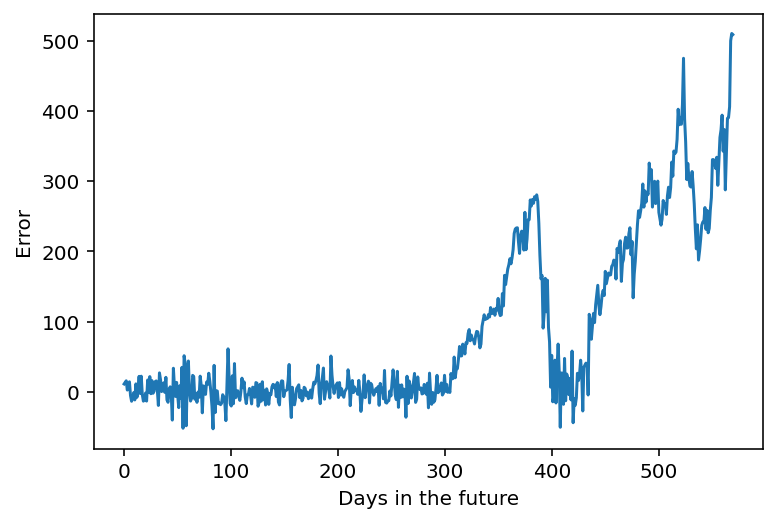

In [54]:
residuals = real - forecast_forest
x_axis = np.linspace(0, len(residuals),len(residuals))
plt.plot(x_axis,residuals)
plt.xlabel("Days in the future")
plt.ylabel("Error")
plt.show()

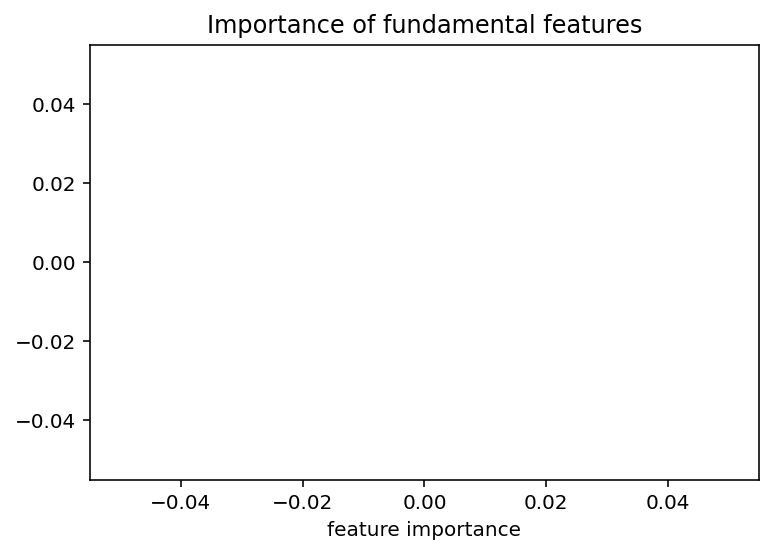

In [55]:
#calculating the impact of the fundamental features:
fundamental_features = features[6:]
weight_fundamental = model3.feature_importances_[6:]
weight_fundamental = sorted(weight_fundamental)
plt.barh(fundamental_features, weight_fundamental)
plt.xlabel("feature importance")
plt.title("Importance of fundamental features")
plt.show()
#The graph below is blank because I deleted the fundamental features from the features list above to train the model
#If you want to see the importance of the features ('EPS', 'Revenue', 'Gross profit', 'Operating Income', 'EBITDA', 
#'Net income', 'PE Ratio' and 'ROE'), simply include them in the features list above

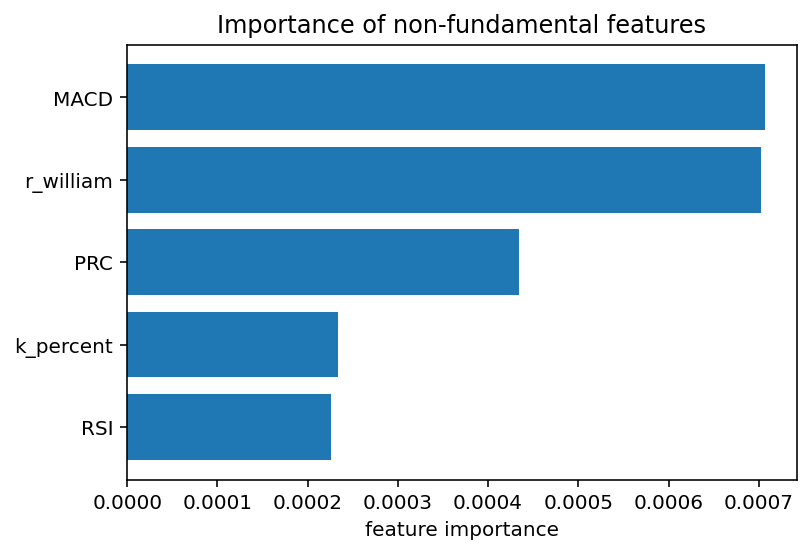

In [56]:
#calculating the impact of the non-fundamental features:
non_fundamental_features = features[1:]
weight_non_fundamental = model3.feature_importances_[1:]
weight_non_fundamental = sorted(weight_non_fundamental)
plt.barh(non_fundamental_features, weight_non_fundamental)
plt.xlabel("feature importance")
plt.title("Importance of non-fundamental features")
plt.show()

Interpretations of these metrics and the importances will be in the write-up.

## Fourth model: Support Vector Regression ##

This model basically uses the same data as random forest, so no further processing is required

In [57]:
regr = make_pipeline(StandardScaler(), SVR(kernel = 'linear', epsilon=0.01))
regr.fit(x_training, y_training)
forecast_svm=regr.predict(x_val)

The above parameters (linear kernel and epsilon of 0.01) is chosen after numerous tests - these are the parameters that yielded the best results. The kernel being linear makes sense because taking a long-term perspective, stocks prices often drops or increases gradually over time, making the linear trend the closest (compared to other kernels such as polynomial). 

The epsilon is a parameter that specifies the margin of tolerance around the decision boundary where no penalties is given to errors. A high epsilon means we are very tolerant of errors. Here, I arrived at a small value of epsilon after numerous tests.

In [58]:
# report performance
real = y_val
mse = mean_squared_error(real, forecast_svm)
rmse = math.sqrt(mean_squared_error(real, forecast_svm))
mape = np.mean(np.abs(np.array(forecast_svm) - real)/np.abs(real))
print('MSE: ', round(mse,2))
print('RMSE: ', round(rmse,2))
print('MAPE: ', round(mape,2))

MSE:  399.72
RMSE:  19.99
MAPE:  0.01


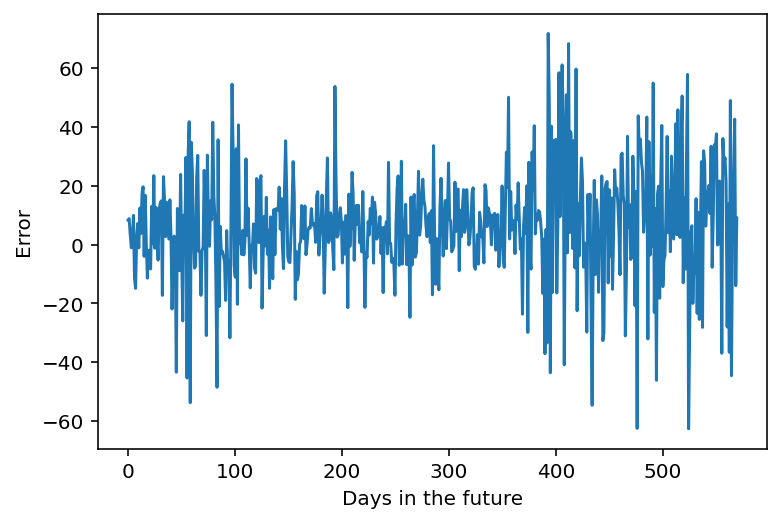

In [59]:
residuals = real - forecast_svm
x_axis = np.linspace(0, len(residuals),len(residuals))
plt.plot(x_axis,residuals)
plt.xlabel("Days in the future")
plt.ylabel("Error")
plt.show()

## Section 2: Testing with other stocks ##

This time with MMM - price has been much more stable over the past few years. Codes for the model are simply copied from above.

#### Facebook Prophet

In [60]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d') 
dta_mmm = pd.read_csv('MMM (1).csv',sep=',', parse_dates=['Date'], 
                  date_parser=dateparse).fillna(0)
dta_mmm = dta_mmm[["Date","Close"]] 
dta_mmm = dta_mmm.rename(columns = {"Date":"ds","Close":"y"})
train_dta_mmm = dta_mmm[0:int(len(dta_mmm)*0.6)] #Training data: 60%
test_dta_mmm = dta_mmm[int(len(dta_mmm)*0.6):] #Test data: the remaining 40%
train_dta_mmm = train_dta_mmm.rename(columns = {"Date":"ds","Close":"y"}) #renaming as required by the model
model_mmm = Prophet() 
model_mmm.add_country_holidays(country_name='US')
model_mmm.fit(train_dta_mmm) # fit the model using the training data
pred_mmm = model_mmm.make_future_dataframe(periods=590) #predict 556 days in the future (40% of the data)
pred_results_mmm = model_mmm.predict(pred_mmm)
prices_mmm = list(pred_results_mmm['yhat'])
predicted_prices_mmm = prices_mmm[884:] #make the list of predicted prices to evaluate the model later
actual_prices_mmm = test_dta_mmm["y"].tolist()
# reporting model performance
mse_mmm = mean_squared_error(actual_prices_mmm, predicted_prices_mmm)
rmse_mmm = math.sqrt(mean_squared_error(actual_prices_mmm, predicted_prices_mmm))
mape_mmm = np.mean(np.abs(np.array(predicted_prices_mmm) - actual_prices_mmm)/np.abs(actual_prices_mmm))
print('MSE: ', round(mse_mmm,2))
print('RMSE:', round(rmse_mmm,2))
print('MAPE: ', round(mape_mmm,2))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE:  356.0
RMSE: 18.87
MAPE:  0.09


#### ARIMA ####

In [61]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
dta_mmm = pd.read_csv('MMM (1).csv',sep=',',index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
dta_mmm_close = dta_mmm['Close']
dta_mmm_log = np.log(dta_mmm_close)
train_data_mmm = dta_mmm_log[:int(len(dta_mmm_log)*0.6)] #train data: 60% of data like with Facebook Prophet
test_data_mmm = dta_mmm_log[int(len(dta_mmm_log)*0.6):] #test data: 40% of data remaining
model_autoARIMA_mmm = auto_arima(train_data_mmm, start_p=0, start_q=0,
                      test='adf', # use adftest to find optimal 'd' (level of integration)
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series
                      d=None, # let model determine 'd'
                      seasonal=True,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5491.281, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5490.986, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5490.913, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5492.946, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5488.541, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.804 seconds


In [62]:
model_arima_mmm = ARIMA(train_data_mmm, order=(0, 1, 0))  #parameter found above
model_fit_mmm = model_arima_mmm.fit(disp=-1)  

D:\Downloads-D\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Downloads-D\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [63]:
# Deriving predictions
pred_mmm, std_error, confint = model_fit_mmm.forecast(590, alpha=0.05)  #forecast 578 days - 40% of the data. Confint 95%

pred_mmm_y = pd.Series(pred_mmm, index=test_data_mmm.index)

# report performance (un-logging the data first)
mse = mean_squared_error(np.exp(test_data_mmm), np.exp(pred_mmm))
rmse = math.sqrt(mean_squared_error(np.exp(test_data_mmm), np.exp(pred_mmm)))
mape = np.mean(np.abs(np.exp(pred_mmm) - np.exp(test_data_mmm))/np.abs(np.exp(test_data_mmm)))
print('MSE: ', round(mse,2))
print('RMSE: ', round(rmse,2))
print('MAPE: ', round(mape,2))

MSE:  1955.66
RMSE:  44.22
MAPE:  0.23


#### Random Forest

In [64]:
dta_mmm2 = pd.read_csv('MMM (1).csv',sep=',', parse_dates=['Date'], 
                  date_parser=dateparse).fillna(0)

#Use the functions to calculate the features in the dataset
dta_mmm2=rsi_cal(dta_mmm2)
dta_mmm2=stoc_oscillator_cal(dta_mmm2)
dta_mmm2=prc_cal(dta_mmm2)
dta_mmm2=macd_cal(dta_mmm2)
dta_mmm2=r_william_cal(dta_mmm2)
#dropping all the NaNs
dta_mmm2=dta_mmm2.dropna()

total = dta_mmm2.count()[0]
valid = 569
train = total - valid #60% of the data to train

#make a copy so we leave the dta3 data set unchanged
dta_mmm2_copy = dta_mmm2
#including different features from above
features = ['Open','RSI','k_percent', 'PRC', 'r_william', 'MACD']
x_dta_mmm2 = dta_mmm2_copy[features]
y_dta_mmm2 = dta_mmm2_copy['Close']
x_training = x_dta_mmm2[:train]
x_val = x_dta_mmm2[train:]
y_training = y_dta_mmm2[:train]
y_val = y_dta_mmm2[train:]
x_val.drop(['RSI','k_percent', 'PRC', 'r_william', 'MACD'], axis=1)
#this makes the test data to be completely independent of the training data - I removed all the technical features

model_mmm2 = RandomForestRegressor(bootstrap=True)
model_mmm2.fit(x_training, y_training)
forecast_forest_mmm2 = model_mmm2.predict(x_val)
real_mmm2 = y_dta_mmm2[train:].tolist()

# report performance
mse_mmm2 = mean_squared_error(real_mmm2, forecast_forest_mmm2)
rmse_mmm2 = math.sqrt(mean_squared_error(real_mmm2, forecast_forest_mmm2))
mape_mmm2 = np.mean(np.abs(np.array(forecast_forest_mmm2) - real_mmm2)/np.abs(real_mmm2))
print('MSE: ', round(mse_mmm2,2))
print('RMSE: ', round(rmse_mmm2,2))
print('MAPE: ', round(mape_mmm2,2))

MSE:  6.9
RMSE:  2.63
MAPE:  0.01


#### Support vector regression ####

In [65]:
regr_mmm2 = make_pipeline(StandardScaler(), SVR(kernel = 'linear', epsilon=0.01))
regr_mmm2.fit(x_training, y_training)
forecast_svm_mmm2=regr_mmm2.predict(x_val)
# report performance
mse = mean_squared_error(real_mmm2, forecast_svm_mmm2)
rmse = math.sqrt(mean_squared_error(real_mmm2, forecast_svm_mmm2))
mape = np.mean(np.abs(np.array(forecast_svm_mmm2) - real_mmm2)/np.abs(real_mmm2))
print('MSE: ', round(mse,2))
print('RMSE: ', round(rmse,2))
print('MAPE: ', round(mape,2))

MSE:  6.14
RMSE:  2.48
MAPE:  0.01


#### Now we test with IBM, a stock that has a downward trend (last 5 years)

##### Facebook Prophet

In [66]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d') 
dta_ibm = pd.read_csv('IBM.csv',sep=',', parse_dates=['Date'], 
                  date_parser=dateparse).fillna(0)
dta_ibm = dta_ibm[["Date","Close"]] 
dta_ibm = dta_ibm.rename(columns = {"Date":"ds","Close":"y"})
train_dta_ibm = dta_ibm[0:int(len(dta_ibm)*0.6)] #Training data: 60%
test_dta_ibm = dta_ibm[int(len(dta_ibm)*0.6):] #Test data: the remaining 40%
train_dta_ibm = train_dta_ibm.rename(columns = {"Date":"ds","Close":"y"}) #renaming as required by the model
model_ibm = Prophet() 
model_ibm.add_country_holidays(country_name='US')
model_ibm.fit(train_dta_ibm) # fit the model using the training data
pred_ibm = model_ibm.make_future_dataframe(periods=590) #predict 556 days in the future (40% of the data)
pred_results_ibm = model_ibm.predict(pred_ibm)
prices_ibm = list(pred_results_ibm['yhat'])
predicted_prices_ibm = prices_ibm[884:] #make the list of predicted prices to evaluate the model later
actual_prices_ibm = test_dta_ibm["y"].tolist()
# reporting model performance
mse_ibm = mean_squared_error(actual_prices_ibm, predicted_prices_ibm)
rmse_ibm = math.sqrt(mean_squared_error(actual_prices_ibm, predicted_prices_ibm))
mape_ibm = np.mean(np.abs(np.array(predicted_prices_ibm) - actual_prices_ibm)/np.abs(actual_prices_ibm))
print('MSE: ', round(mse_ibm,2))
print('RMSE:', round(rmse_ibm,2))
print('MAPE: ', round(mape_ibm,2))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE:  147.99
RMSE: 12.17
MAPE:  0.07


##### ARIMA

In [67]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
dta_ibm = pd.read_csv('IBM.csv',sep=',',index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
dta_ibm_close = dta_ibm['Close']
dta_ibm_log = np.log(dta_ibm_close)
train_data_ibm = dta_ibm_log[:int(len(dta_ibm_log)*0.6)] #train data: 60% of data like with Facebook Prophet
test_data_ibm = dta_ibm_log[int(len(dta_ibm_log)*0.6):] #test data: 40% of data remaining
model_autoARIMA_ibm = auto_arima(train_data_ibm, start_p=0, start_q=0,
                      test='adf', # use adftest to find optimal 'd' (level of integration)
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series
                      d=None, # let model determine 'd'
                      seasonal=True,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5230.813, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5228.815, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5228.815, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5232.692, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5228.901, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.800 seconds


In [68]:
model_arima_ibm = ARIMA(train_data_ibm, order=(0, 1, 0))  #parameter found above
model_fit_ibm = model_arima_ibm.fit(disp=-1)  

D:\Downloads-D\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Downloads-D\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [69]:
# Deriving predictions
pred_ibm, std_error, confint = model_fit_ibm.forecast(590, alpha=0.05)  #forecast 578 days - 40% of the data. Confint 95%

pred_ibm_y = pd.Series(pred_ibm, index=test_data_ibm.index)

# report performance (un-logging the data first)
mse = mean_squared_error(np.exp(test_data_ibm), np.exp(pred_ibm))
rmse = math.sqrt(mean_squared_error(np.exp(test_data_ibm), np.exp(pred_ibm)))
mape = np.mean(np.abs(np.exp(pred_ibm) - np.exp(test_data_ibm))/np.abs(np.exp(test_data_ibm)))
print('MSE: ', round(mse,2))
print('RMSE: ', round(rmse,2))
print('MAPE: ', round(mape,2))

MSE:  126.02
RMSE:  11.23
MAPE:  0.07


##### Random Forest

In [70]:
dta_ibm2 = pd.read_csv('IBM.csv',sep=',', parse_dates=['Date'], 
                  date_parser=dateparse).fillna(0)
dta_ibm2=rsi_cal(dta_ibm2)
dta_ibm2=stoc_oscillator_cal(dta_ibm2)
dta_ibm2=prc_cal(dta_ibm2)
dta_ibm2=macd_cal(dta_ibm2)
dta_ibm2=r_william_cal(dta_ibm2)
#dropping all the NaNs
dta_ibm2=dta_ibm2.dropna()

total = dta_ibm2.count()[0]
valid = 569
train = total - valid 

#make a copy so we leave the dta3 data set unchanged
dta_ibm2_copy = dta_ibm2
#including different features from above
features = ['Open','RSI','k_percent', 'PRC', 'r_william', 'MACD']
x_dta_ibm2 = dta_ibm2_copy[features]
y_dta_ibm2 = dta_ibm2_copy['Close']
x_training = x_dta_ibm2[:train]
x_val = x_dta_ibm2[train:]
y_training = y_dta_ibm2[:train]
y_val = y_dta_ibm2[train:]
x_val.drop(['RSI','k_percent', 'PRC', 'r_william', 'MACD'], axis=1)
#this makes the test data to be completely independent of the training data - I removed all the technical features

model_ibm2 = RandomForestRegressor(bootstrap=True)
model_ibm2.fit(x_training, y_training)
forecast_forest_ibm2 = model_ibm2.predict(x_val)
real_ibm2 = y_dta_ibm2[train:]

# report performance
mse_ibm2 = mean_squared_error(real_ibm2, forecast_forest_ibm2)
rmse_ibm2 = math.sqrt(mean_squared_error(real_ibm2, forecast_forest_ibm2))
mape_ibm2 = np.mean(np.abs(np.array(forecast_forest_ibm2) - real_ibm2)/np.abs(real_ibm2))
print('MSE: ', round(mse_ibm2,2))
print('RMSE: ', round(rmse_ibm2,2))
print('MAPE: ', round(mape_ibm2,2))

MSE:  17.93
RMSE:  4.23
MAPE:  0.02


#### Support Vector Regression ####

In [71]:
regr_ibm2 = make_pipeline(StandardScaler(), SVR(kernel = 'linear', epsilon = 0.01))
regr_ibm2.fit(x_training, y_training)
forecast_svm_ibm2=regr_ibm2.predict(x_val)
# report performance
mse = mean_squared_error(real_ibm2, forecast_svm_ibm2)
rmse = math.sqrt(mean_squared_error(real_ibm2, forecast_svm_ibm2))
mape = np.mean(np.abs(np.array(forecast_svm_ibm2) - real_ibm2)/np.abs(real_ibm2))
print('MSE: ', round(mse,2))
print('RMSE: ', round(rmse,2))
print('MAPE: ', round(mape,2))

MSE:  3.02
RMSE:  1.74
MAPE:  0.01


## Section 3: Optimization

The following optimization is based on a tutorial from Kim (2018).

Kim, R. (2018, February 27). Tthustla/efficient_frontier. Retrieved March 20, 2021, from https://github.com/tthustla/efficient_frontier/blob/master/Efficient%20_Frontier_implementation.ipynb

In [72]:
ibm_price = forecast_svm_ibm2.tolist()
mmm_price = forecast_svm_mmm2.tolist()
goog_price= forecast_svm.tolist()
price_dict = {'IBM': ibm_price, 'MMM': mmm_price,'GOOG': goog_price}

In [73]:
df = pd.DataFrame(data=price_dict)

In [74]:
def annualise(allocation, mean_returns, covariance):
    """Function to annualise the standard deviation and return of each portfolio

    Parameters
    ----------
    allocation
        The weight given to each stock in the portfolio
    mean_returns
        The mean return of each stock in the portfolio
    covariance
        The covariance matrix of the stocks in the portfolio
    
    Returns
    -------
    std_annual
        annualised standard deviation
    return_annual
        annualised return

    """
    std_annual = np.sqrt(np.dot(allocation.T, np.dot(covariance, allocation))) * np.sqrt(252)
    return_annual = np.sum(mean_returns*allocation ) *252 #252 trading days per year
    return std_annual, return_annual

In [75]:
def create_random_portfolios(mean_returns, covariance, risk_free_rate):
    """Function to create 50000 random portfolios using the above stocks for the efficient frontier.

    Parameters
    ----------
    mean_returns
        The mean return of each stock in the portfolio
    covariance
        The covariance matrix of the stocks in the portfolio
    risk_free_rate
        Current risk-free rate. We want to invest the cash portion of the portfolio in risk-free treasury
    
    Returns
    -------
    results
        list of standard deviation, return and Sharpe ratio of each portfolio
    list_weights
        list of portfolios

    """
    list_weights = []
    results = np.zeros((3,50000)) #50000 portfolios
    for i in range(50000):
        allocation = np.random.random(len(df.columns)) #randoming the allocation 
        allocation = allocation/sum(allocation) #normalizing the randomed vectors so they sum to 1
        list_weights.append(allocation)
        std_dev = annualise(allocation, mean_returns, covariance)[0] #annualise the std and return of the portfolio
        returns = annualise(allocation, mean_returns, covariance)[1]
        results[0,i] = std_dev  
        results[1,i] = returns 
        results[2,i] = (returns - risk_free_rate) / std_dev #Sharpe ratio
    return results, list_weights

In [76]:
returns = df.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.0083

In [77]:
cov_matrix

,IBM,MMM,GOOG
IBM,0.000319,0.000181,0.000171
MMM,0.000181,0.000325,0.000141
GOOG,0.000171,0.000141,0.000381


In [78]:
'''
Now we define function to plot the efficient frontier with the optimal portfolio highlighted using the results above.
The optimal portfolio is found by taking the portfolio with the maximum Sharpe ratio (excess returns given the risk)
among the 50000 portfolios that we randomly created. We also display the portfolio with the smallest possible 
risk.
'''

def efficient_frontier(mean_returns, covariance, risk_free_rate):
    """Function graph the efficient frontier and print out the optimal portfolios

    Parameters
    ----------
    mean_returns
        The mean return of each stock in the portfolio
    covariance
        The covariance matrix of the stocks in the portfolio
    risk_free_rate
        Current risk-free rate. We want to invest the cash portion of the portfolio in risk-free treasury
    """
    results = create_random_portfolios(mean_returns, covariance, risk_free_rate)[0]
    weights = create_random_portfolios(mean_returns, covariance, risk_free_rate)[1]
    #For the portfolio with maximum sharpe
    index_max_sharpe = np.argmax(results[2]) #the maximum sharpe ratio among 30000 portfolios randomed
    std_max_sharpe = results[0,index_max_sharpe]
    return_max_sharpe = results[1,index_max_sharpe]
    allocation_max_sharpe = weights[index_max_sharpe]
    #For the portfolio with the lowest risk
    index_min_risk = np.argmin(results[0])
    std_min_risk = results[0, index_min_risk]
    return_min_risk = results[1, index_min_risk]
    allocation_min_risk = weights[index_min_risk]
    #Printing out the results    
    print("Portfolio with max Sharpe")
    print("Return:", return_max_sharpe)
    print("Risk:", std_max_sharpe)
    print(df.columns.tolist())
    print(allocation_max_sharpe)
    print("Portfolio with minimum risk")
    print("Return:", return_min_risk)
    print("Risk:", std_min_risk)
    print(df.columns.tolist())
    print(allocation_min_risk)
    #Visualizing with a scatterplot
    plt.figure(figsize = (15,10))
    std_applicable = []
    return_applicable=[]
    for i in range(len(results[0,:])): #only display the upper part of the frontier
        if results[1,i] > return_min_risk:
            std_applicable.append(results[0,i])
            return_applicable.append(results[1,i])
        else:
            pass
    plt.scatter(std_applicable,return_applicable, marker='o', s=10) #all portfolios
    plt.scatter(std_max_sharpe,return_max_sharpe,marker='*',color='red',s=500, label='Maximum Sharpe ratio')
    plt.scatter(std_min_risk,return_min_risk,marker='*',color='green',s=500, label='Minimum risk')
    plt.legend()
    plt.title('Efficient frontier with optimized portfolios')
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.show()

Portfolio with max Sharpe
Return: 0.20250940123287245
Risk: 0.30911617330510394
['IBM', 'MMM', 'GOOG']
[0.48409942 0.14527657 0.37062401]
Portfolio with minimum risk
Return: 0.01455630436350243
Risk: 0.2370211256853837
['IBM', 'MMM', 'GOOG']
[0.21092938 0.28417337 0.50489726]


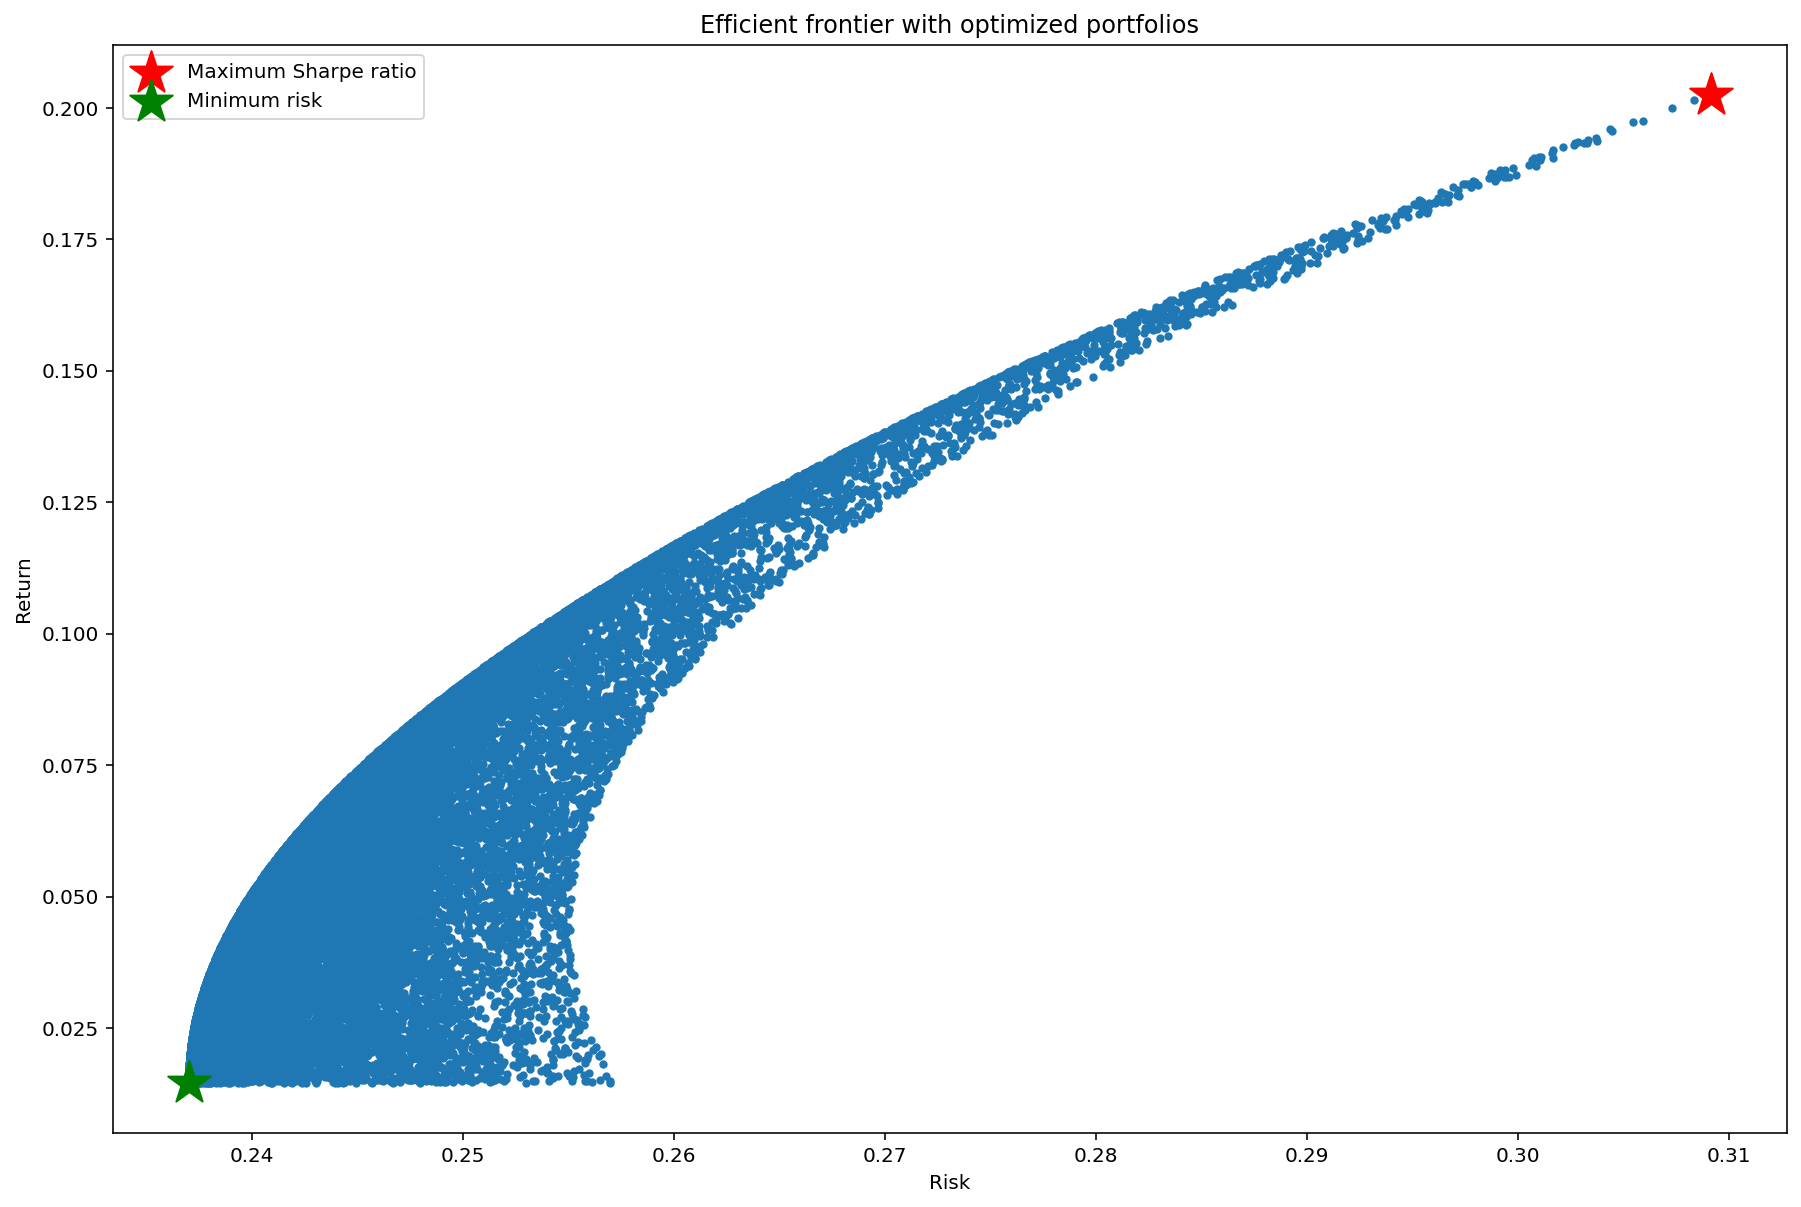

In [79]:
efficient_frontier(mean_returns, cov_matrix, risk_free_rate)

Every portfolio on the frontier from the gold star upwards is efficient - the maximum sharpe (red star) portfolio is just highlighted as a suggestion